In [2]:
def m2fea2m2cs(x,y,z):
    return -y,-x,-z
def ocs2zcs(x,y,z):
    return -x,y,-z

def m2fea2zcs(x,y,z):
    return y, -x, z

In [6]:
a,b,c = m2fea2m2cs(1,2,3)
a,b,c = ocs2zcs(a,b,c)
print(a,b,c)
a,b,c = m2fea2zcs(1,2,3)
print(a,b,c)

2 -1 3
2 -1 3


In [75]:
import numpy as np
import scipy.interpolate as interpolate
def deRotateBendingModes(coeff, rAngle, mirror):
    '''
    input parameters:
         coeff: the bending mode coefficients in CCS
         rAngle: camera rotator angle, in degrees (counterclockwise when look from the sky)
         mirror: an mirror object, either M1M3 or M2
    output:
        rotated coeff in OCS
    Note: this is proof of concept for now. Since this needs to be done in real time,
        we should store bending modes on a grid, so that we can avoid interpolating 
        scattered data all the time. It is slow.
    '''
    nb = len(coeff) #number of bending modes
    nNodes = len(mirror.bx) #number of surface nodes
    z_ccs = np.zeros(nNodes) #surface shape in CCS
    for i in range(nb):
        z_ccs += mirror.bz[:,i]*coeff[i]
    c = np.cos(np.radians(rAngle))
    s = np.sin(np.radians(rAngle))
    x_ocs = mirror.bx*c - mirror.by*s #document-18499 Eq. (9)
    y_ocs = mirror.bx*s + mirror.by*c #x and y in OCS
    f = interpolate.Rbf(x_ocs, y_ocs, z_ccs) 
    z_ocs = f(mirror.bx, mirror.by)
    return np.linalg.pinv(mirror.bz).dot(z_ocs)

In [12]:
class mirror(object):
    def __init__(self, file):
        aa = np.loadtxt(file)
        self.bx = aa[:,1]
        self.by = aa[:,2]
        self.bz = aa[:,3:]
M1M3 = mirror('/Users/bxin/wavefront/activeoptics/matlab/m1m3/M1M3_ML/data/M1M3_1um_156_grid.txt')
M2 = mirror('/Users/bxin/wavefront/activeoptics/matlab/m2/M2_FEA/data/M2_1um_72_grid.txt')

(-4.5912828718040615,
 4.591284871804062,
 -4.5933793834069165,
 4.593378383406916)

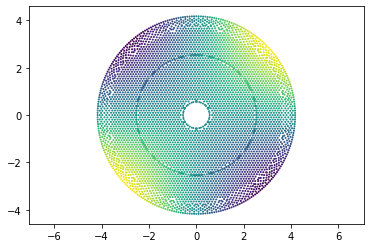

In [31]:
plt.scatter(M1M3.bx, M1M3.by, 1, M1M3.bz[:,0])
plt.axis('equal')

(-4.5912828718040615,
 4.591284871804062,
 -4.5933793834069165,
 4.593378383406916)

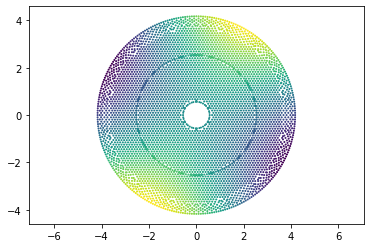

In [35]:
plt.scatter(M1M3.bx, M1M3.by, 1, coeff)
plt.axis('equal')

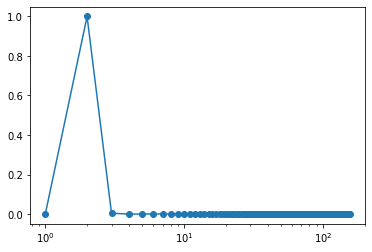

In [44]:
import matplotlib.pyplot as plt
coeff_ccs = np.zeros(20)
coeff_ccs[0] = 1
coeff = deRotateBendingModes(coeff_ccs, 45, M1M3)

plt.semilogx(np.arange(1,157), coeff,'-o');

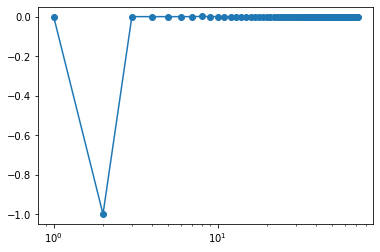

In [48]:
coeff_ccs = np.zeros(20)
coeff_ccs[0] = 1
coeff = deRotateBendingModes(coeff_ccs, 45, M2)

plt.semilogx(np.arange(1,72+1), coeff,'-o');

In [71]:
def deRotateHexapod(cmd, rAngle):
    '''
    input parameters:
         cmd: hexapod command [dz, dx,dy,rx,ry] in CCS, with rx and ry in degrees
         rAngle: camera rotator angle, in degrees (counterclockwise when look from the sky)
    output:
        rotated hexapod cmd in OCS, with rx and ry in degrees
    Note: 
        if v1 and v2 are 2 vectors in CS1, and v2 = O v1
           T transforms v1 and v2 into CS2
           (T v2) = (T O T^-1) (T v1)
        see Document-18499 for more details on T and O.
    '''
    [dz, dx, dy, rx, ry] = cmd
    transM = np.array([[1,0,0,dx], [0,1,0,dy], [0,0,1,dz], [0,0,0,1]]) #document-18499, Eq (3)
    c = np.cos(np.radians(rx))
    s = np.sin(np.radians(rx))
    rxT = np.array([[1, 0, 0 ,0], [0, c, -s, 0], [0, s, c, 0], [0,0,0,1]])#document-18499, Eq (5)
    c = np.cos(np.radians(ry))
    s = np.sin(np.radians(ry))
    ryT = np.array([[c, 0, s ,0], [0, 1, 0, 0], [-s, 0, c, 0], [0,0,0,1]]) ##document-18499, Eq (7)
    O = transM.dot(rxT).dot(ryT)
    c = np.cos(np.radians(rAngle))
    s = np.sin(np.radians(rAngle))
    T = np.array([[c, -s, 0,0], [s,c,0,0], [0,0,1,0], [0,0,0,1]]) ##document-18499, Eq (9)
    mm = T.dot(O).dot(np.linalg.inv(T))
    print(mm)
    # we can analytically do transM*rxT*ryT on paper, then match matrix elements to mm above.
    # transM * rxT * ryT = 
    # [c_ry,      0,    -s_ry,      dx],
    # [-s_rx*s_ry,0,    -s_rx*c_ry, dy],
    # [c_rx*s_ry, s_rx, c_rx*c_ry,  dz],
    # [0,         0,      0,         1]
    [dx, dy, dz] = mm[:-1,-1]
    rx = np.degrees(np.arcsin(mm[2,1]))
    ry = np.degrees(np.arcsin(-mm[0,2]))
    return dz, dx, dy, rx, ry

In [72]:
cmd_ccs = [3,1,2, 0, 0.01]
aa = deRotateHexapod(cmd_ccs, 90)
print(aa)

[[ 1.00000000e+00 -9.32621869e-25  1.06870594e-20 -2.00000000e+00]
 [-9.32621869e-25  9.99999985e-01  1.74532924e-04  1.00000000e+00]
 [-1.06870594e-20 -1.74532924e-04  9.99999985e-01  3.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(3.0, -2.0, 1.0000000000000002, -0.01, -6.123233964649371e-19)


In [81]:
def deRotateCmd(aos_cmd_ccs, rAngle, M1M3, M2):
    '''
    input parameters:
         aos_cmd_ccs: aos commands determined in CCS. This is a 50x1 vector, ordered as
                 [M2 hexapod (dz, dx, dy, rx, ry), Camera hexapod (dz, dx, dy, rx, ry), 
                    M1M3 bending modes 1-20, M2 bending modes 1-20]
         rAngle: camera rotator angle, in degrees (counterclockwise when look from the sky)
         M1M3 and M2: mirror objects, with bending mode data
    output:
        aos commands which have been transformed into OCS
    '''
    m2_hex = aos_cmd_ccs[:5]
    cam_hex = aos_cmd_ccs[5:10]
    m1m3_bm = aos_cmd_ccs[10:30]
    m2_bm = aos_cmd_ccs[30:50]
    m1m3_bm_ocs = deRotateBendingModes(m1m3_bm, rAngle, M1M3)
    m2_bm_ocs = deRotateBendingModes(m2_bm, rAngle, M2)
    m2_hex_ocs = deRotateHexapod(m2_hex, rAngle)
    cam_hex_ocs = deRotateHexapod(cam_hex, rAngle)
    return np.hstack((m2_hex_ocs, cam_hex_ocs, m1m3_bm_ocs[:20], m2_bm_ocs[:20]))

aa = deRotateCmd(np.zeros(50), 0.01, M1M3, M2)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.71050543e-20  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-2.71050543e-20  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [82]:
aa.shape

(50,)

In [83]:
156+72+10

238